In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random
import librosa
import os
import soundfile as sf
from scipy.io import wavfile #for audio processing
import tensorflow as tf

from keras.models import Model , Sequential
from keras.utils import Sequence
import keras

In [33]:
os.chdir("/home/atharva/conversational_robot/assignments/Speech_Recog_Assn/speech_commands_v0.01")

dirs = os.listdir()

len_dirs = len(dirs)

print(dirs[4])
print(len_dirs)

one
30


In [34]:
char_map_str = """
<SPACE> 0
a 1
b 2
c 3
d 4
e 5
f 6
g 7
h 8
i 9
j 10
k 11
l 12
m 13
n 14
o 15
p 16
q 17
r 18
s 19
t 20
u 21
v 22
w 23
x 24
y 25
z 26
_ 27
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    if ch == "<SPACE>":
        ch = " "
    char_map[ch] = int(index)
    index_map[int(index)] = ch

index_map[0] = ' '

In [35]:
char_map

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '_': 27}

In [36]:
list_IDs = []

for direc in os.listdir():
        file = [ f for f in os.listdir(os.getcwd() + '/' + direc ) if f.endswith('.wav')]
        for f in file:
            list_IDs.append(direc + '/' + f)

print("Total IDs :",len(list_IDs))
print((list_IDs[0]),"\n",(list_IDs[500]))

Total IDs : 64721
up/042186b8_nohash_0.wav 
 up/96ab6565_nohash_4.wav


In [37]:
max_label = 8

In [90]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, all_classes, list_IDs, max_label, char_map, total_timedistributed_output = 101, 
                 batch_size = 40, noise_factor = 0.1 , add_noise = False , normalise = False ,
                 dim = (101,198) ,shuffle = True ):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.all_classes = all_classes
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.noise_factor = noise_factor
        self.add_noise = add_noise
        self.normalise = normalise
        self.max_label = max_label
        self.char_map  = char_map
        self.total_timedistributed_output = total_timedistributed_output
        self.on_epoch_end()

    def __len__(self):
        
        'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))
        return self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)
        
        input_length = np.array([self.total_timedistributed_output for _ in range(self.batch_size)])
        label_length = np.array([self.max_label for _ in range(self.batch_size)])
        
        inputs = {"the_inputs": X, "the_labels": Y, "input_length":input_length, "label_length": label_length}
        outputs = {"ctc": Y}
        return (inputs, outputs)
#         return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 101, 990 ))
        Y = np.empty((self.batch_size , 44 ), dtype=int)
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            sample = self.__graph_spectrogram(os.getcwd() + '/' + ID)
            if(sample.shape != self.dim):
                a = np.zeros(self.dim)
                a[: , :sample.shape[1]] = sample
                sample = a    
            if(self.add_noise):
                sample = self.__add_noise(sample , self.noise_factor)
            if(self.normalise):
                sample = self.__normalise_spectrogram(sample)
                
            lab = self.__get_label(ID.split('/')[0] , self.max_label)
                
            for j in range(0,4):
                
                temp_ID = random.choice(list_IDs_temp)
                temp_sample = self.__graph_spectrogram(os.getcwd() + '/' + temp_ID)
                if(temp_sample.shape != self.dim):
                    a = np.zeros(self.dim)
                    a[: , :temp_sample.shape[1]] = temp_sample
                    temp_sample = a    
                if(self.add_noise):
                    temp_sample = self.__add_noise(temp_sample , self.noise_factor)
                if(self.normalise):
                    temp_sample = self.__normalise_spectrogram(temp_sample)
                
                sample = np.append(sample,temp_sample)
                
                
                temp_lab = self.__get_label(temp_ID.split('/')[0] , self.max_label)
                
                lab = np.append(lab,27)
                lab = np.append(lab,temp_lab)
                
            sample = sample.reshape(101,990)
            X[i,] = sample

            # Store label
            Y[i,] = lab

        return X, Y
    
    def __graph_spectrogram(self, wav_file):
        rate, data = self.__get_wav_info(wav_file)
        nfft = 200 # Length of each window segment
        fs = 8000 # Sampling frequencies
        noverlap = 120 # Overlap between windows
        nchannels = data.ndim
        if nchannels == 1:
            pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
        elif nchannels == 2:
            pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
        return pxx

    # Load a wav file
    def __get_wav_info(self, wav_file):
        rate , data = wavfile.read(wav_file)
        return rate, data

    def __modify_spectrogram_shape(self, sample ,shape = (101,198) ):
        a = np.zeros(shape)
        a[: , :sample.shape[1]] = sample
        return sample

    def __add_noise(self, sample , noise_factor):
        noise = np.random.randn(sample.shape)
        augmented_data = sample + noise_factor * noise
        augmented_data = augmented_data.astype(type(sample[0]))
        return augmented_data

    def __normalise_spectrogram(self, sample):
        mean = np.mean(sample, axis=0)
        std = np.std(sample, axis=0)
        sample = (sample - mean) / std

        return sample
    
    def __get_label(self, Y , max_label):
        new = [] 
        for c in Y:
            if c not in self.char_map:
                continue
            elif c == "_":
                continue
            else:
                ch = self.char_map[c]
                new.append(ch)

        while(len(new) < max_label):
            new.append(27)
        label = np.array(new)

        return label

In [91]:
training_generator = DataGenerator(dirs ,list_IDs, 8, char_map)
# X, Y = training_generator.__getitem__(0)

# print(Y[2])

In [92]:
print(X[4].shape)

(101, 990)


In [93]:
a = [1,2,3]
b = [4,5,6]
c = np.append(a,b)
print(c)

[1 2 3 4 5 6]


In [106]:
from keras.layers import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length )    
    
class CTC():
    """
    Usage:
        sr_ctc = CTC(enter input_size and output_size)
        sr_ctc.build()
        sr_ctc.m.compile()
        sr_ctc.tm.compile()
    """       
    def __init__(self,
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None
        self.tm = None
                   
    def build(self, 
              conv_filters = 200,
              conv2d_filters = 13,
              conv_size = 5,
              conv2d_strides = 1,
              conv_strides = 1,
              act = 'relu',
              rnn_layers = 2,
              LSTM_units = 128,
              drop_out = 0.8):
           
        input_data = Input(shape = self.input_size, name = 'the_inputs')
#         x = Conv2D(conv2d_filters,
#                    conv_size,
#                    strides = (conv2d_strides, conv2d_strides),
#                    padding = "same",
#                    name = "conv2d1")(input_data)
#         x = BatchNormalization()(x)
#         x = Activation(act)(x)
#         x = Conv2D(conv2d_filters,
#                    conv_size,
#                    strides = (conv2d_strides , conv2d_strides),
#                    padding = "same",
#                    name = "conv2d2")(x)
#         x = BatchNormalization()(x)
#         x = Activation(act)(x)
#         x = Reshape([606,-1])(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d1')(input_data)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d2')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
#         x = Reshape([101])(x)
#         x = Dense(23 , activation="softmax", name = "dense")(x)
#         x = Reshape([23,-1])(x)
        for _ in range(rnn_layers):          
            x = Bidirectional(LSTM(LSTM_units, 
                                   return_sequences = True))(x)
            x = Dropout(drop_out)(x)
            x = BatchNormalization()(x)
        y_pred = TimeDistributed(Dense(self.output_size, 
                                       activation = 'softmax'))(x)        
        # ctc inputs
        labels = Input(name='the_labels', shape=[None,], dtype='int32')
        input_length = Input(name='input_length', shape=[1], dtype='int32')
        label_length = Input(name='label_length', shape=[1], dtype='int32')    
        # Keras doesn't currently support loss funcs with extra parameters
        # so CTC loss is implemented in a lambda layer
        loss_out = Lambda(ctc_lambda_func, 
                          output_shape=(1,), 
                          name='ctc')([y_pred,
                                        labels,
                                        input_length,
                                        label_length])        
        self.tm = Model(inputs = input_data,
                        outputs = y_pred)
        self.m = Model(inputs = [input_data, 
                                 labels, 
                                 input_length, 
                                 label_length], 
                        outputs = loss_out)
        return self.m, self.tm

In [107]:
def ctc(y_true, y_pred):
    return y_pred

In [108]:
model_ctc = CTC((101,990), 28)
model_ctc.build()

(<keras.engine.training.Model at 0x7ff330598f60>,
 <keras.engine.training.Model at 0x7ff33058be80>)

In [109]:
model_ctc.m.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 101, 990)     0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, 101, 200)     990200      the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 101, 200)     800         conv1d1[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 101, 200)     0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [110]:
model_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])

Epoch 1/2


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1d1_3/convolution (defined at /home/atharva/virtualenv/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
	 [[ctc_3/GatherNd/_256]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1d1_3/convolution (defined at /home/atharva/virtualenv/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_35253]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


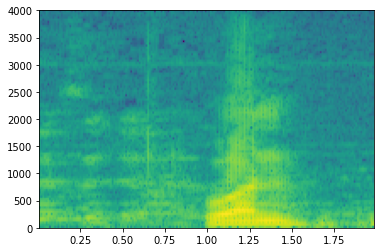

In [111]:
model_ctc.m.fit_generator(training_generator, epochs=2)